In [1]:
from skimage import color, io
import skimage
import numpy as np
from matplotlib import pyplot as plt

In [2]:
image = skimage.img_as_ubyte(skimage.color.rgb2gray(skimage.io.imread('test.jpg')))

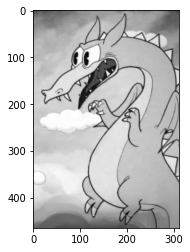

In [3]:
plt.imshow(image, 'gray')
plt.show()

In [4]:
class RLECoder:
    def encode(self, data):
        encoded = np.zeros((data.size, 2), dtype=int)
        flat_data = data.ravel()
        encoded_ptr = -1
        for intensity in flat_data:
            if intensity == encoded[encoded_ptr][1]:
                encoded[encoded_ptr][0] += 1
            else:
                encoded_ptr += 1
                encoded[encoded_ptr] = (1, intensity)
        first_zero_idx = np.where(encoded == 0)[0][0]
        return np.resize(encoded, (first_zero_idx, 2))
    
    def decode(self, encoded):
        elems = 0
        for pair_idx in range(encoded.shape[0]):
            elems += encoded[pair_idx][0]
        decoded = np.zeros(elems, dtype=int)
        encoded_ptr = 0
        for i in range(elems):
            if encoded[encoded_ptr][0] == 0:
                encoded_ptr += 1
            decoded[i] = encoded[encoded_ptr][1]
            encoded[encoded_ptr][0] -= 1
        return decoded

In [5]:
seq = np.array([255, 255, 255, 3, 4, 4, 4], dtype=int)
coder = RLECoder()
print(coder.encode(seq))
print(coder.decode(coder.encode(seq)))

[[  3 255]
 [  1   3]
 [  3   4]]
[255 255 255   3   4   4   4]


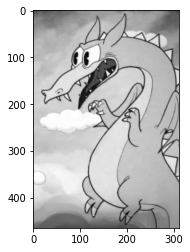

In [6]:
plt.imshow(coder.decode(coder.encode(image)).reshape(image.shape), 'gray')

In [97]:
from bitarray import bitarray

In [141]:
class HuffmanTree:
    def __init__(self):
        self.root = None
        self.left = None
        self.right = None
        self.value = None
        self.freq_sum = 0
        
    def build(self, values):
        unique, frequencies = np.unique(values, return_counts=True)
        desc_roots = np.flip(np.argsort(frequencies))
        desc_values, desc_freq = unique[desc_roots], frequencies[desc_roots]
        print(desc_values)
        freq_total = np.sum(desc_freq)
        forest = []
        desc_freq = list(desc_freq)
        for i in range(unique.size):
            tree = HuffmanTree()
            tree.value = desc_values[i]
            tree.freq_sum = desc_freq[i]
            forest.append(tree)
        while len(forest) > 1:
            merged = self._merge(forest[-1], forest[-2])
            forest.pop()
            forest.pop()
            desc_freq.pop()
            desc_freq.pop()
            inserted = False
            for i in range(len(forest) - 1, -1, -1):
                if merged <= forest[i]:
                    inserted = True
                    forest.insert(i + 1, merged)
                    desc_freq.insert(i + 1, merged.freq_sum)
                    break
            if not inserted:
                forest.insert(0, merged)
                desc_freq.insert(0, merged.freq_sum)
        self.root = forest[0]
        return self.root
    
    def _traverse(self, prefix=''):
        if self.value is not None:
            return {self.value: bitarray(prefix)}
        else:
            cur_result = {}
            if self.left is not None:
                left_value = self.left._traverse(prefix + '0')
            if self.right is not None:
                right_value = self.right._traverse(prefix + '1')
            cur_result.update(left_value)
            cur_result.update(right_value)
            return cur_result
    
    def get_code_dict(self):
        return self._traverse()
        
    def _merge(self, left, right):
        tree = HuffmanTree()
        tree.left = left
        tree.right = right
        tree.freq_sum = left.freq_sum + right.freq_sum
        return tree
        
    def __lt__(self, other):
        return self.freq_sum < other.freq_sum

Just to check neerc ifmo example correctness (the tree came out to be a little different but still correct)

In [161]:
tree = HuffmanTree().build(list('abracadabra'))

['a' 'r' 'b' 'd' 'c']


In [162]:
tree.right.right.left.freq_sum

2

In [163]:
tree.freq_sum

11

In [164]:
abracadabra_codes = tree.get_code_dict()

In [169]:
abracadabra_codes

{'a': bitarray('0'),
 'c': bitarray('100'),
 'd': bitarray('101'),
 'b': bitarray('110'),
 'r': bitarray('111')}

In [167]:
a = bitarray()
a.encode(abracadabra_codes, list('abracadabra'))

(address, size (in bytes), endianness, unused (bits), allocated):

In [171]:
a.buffer_info()

(140687178464064, 3, 'big', 1, 4)

In [172]:
a.decode(abracadabra_codes)

['a', 'b', 'r', 'a', 'c', 'a', 'd', 'a', 'b', 'r', 'a']

23 bits, encoding is correct

In [173]:
tree = HuffmanTree().build(image.ravel())

[194 191 198 195 199 226 224 192 196 200 197 225 193 188 186 190 187 201
 223 227 189 185 211 251 202 183 208 212 206 207 222 203 210 184 182 213
 221 209 214 205 204 181 215 220 179 219 180 218 217 216 228 178 175 167
 177 176 174 166 168 250 172 169 158 173 252 171 159 165 154 164 170 155
 157 153 152 229 156 163 242 160 248 150 126 149 161 162 151 128 147 249
 127 148 233 230 130 241 146 125 231 132 232 234 133 131 142 129 103 235
 100 145 116 109 117 136 101 236 104 115 140 118 124 106 144 137 138  98
 108 139 240  97  99 244 102 121 110 123 134 114 135 143 141 120 107 113
 111 119 238 239 122  96  95 105 243  80 112  94 237  90  83  91 247  82
  86  81  89  79  92 245  84  88  85  93 246  78 253  87  56  57  76  77
  72  68  60  66  73  59  52  58  62  71  75  63  32 254  64  65  70  67
  33  31  54  74  61  55  69  50  30  53  48  51  47  35  49  29  45  46
  28  34  43  26  41  42  38  44  39  24  40  23  25  27  37  20  36  22
  21  19  18  17  16  15  12  11  14   8  13  10   

In [176]:
img_codes = tree.get_code_dict()

In [177]:
img_codes

{202: bitarray('000000'),
 251: bitarray('000001'),
 211: bitarray('000010'),
 185: bitarray('000011'),
 78: bitarray('000100000'),
 246: bitarray('000100001'),
 232: bitarray('00010001'),
 176: bitarray('0001001'),
 189: bitarray('000101'),
 132: bitarray('00011000'),
 231: bitarray('00011001'),
 125: bitarray('00011010'),
 12: bitarray('0001101100000'),
 8: bitarray('00011011000010'),
 14: bitarray('00011011000011'),
 16: bitarray('000110110001'),
 21: bitarray('00011011001'),
 51: bitarray('0001101101'),
 93: bitarray('000110111'),
 146: bitarray('00011100'),
 241: bitarray('00011101'),
 177: bitarray('0001111'),
 167: bitarray('0010000'),
 130: bitarray('00100010'),
 85: bitarray('001000110'),
 48: bitarray('0010001110'),
 22: bitarray('00100011110'),
 36: bitarray('00100011111'),
 227: bitarray('001001'),
 223: bitarray('001010'),
 175: bitarray('0010110'),
 230: bitarray('00101110'),
 88: bitarray('001011110'),
 53: bitarray('0010111110'),
 30: bitarray('0010111111'),
 201: bitar

Encoder work consists of iterating through every symbol and writing down the bit code but since there is no standard library bit sets or something similar and I don't want to use strings for bit encoding, I shall use the bitarray module which is written in C.

In [178]:
encoded = bitarray()
encoded.encode(img_codes, image.ravel())
encoded

bitarray('010010111001111011001111011011000111010010001010010001010010001010010001010000111010000111010000111011101001001111011010010111011010011010111000010000101010111000011010011011010011011010011011010011010010000011010011011010011010000101011010011011010011011010011010000101010000101011010011010000101000110111000110111011011110011011110011101101011101101011101101110000101011110000011110000011101101011101101011011110011011110011011110011011110011011110011011110011011110011011110000110111000110111000110111010000101000110111011011110011110000111010100110001110111010111101011001101011001110001110100110010110101101011101100110110010100110010110001110111010111111010111101011001101011001101011001100100010011101000011101000011101000011101000011101000011101000011101000011101000011101000100100010011101000111011101100110011011000100011110000100010000110001111011100001100010100110110100101111101010111101010111010000010100100111110101111010110011010110011010110011010110010100101010100100111011

Initial size:

In [179]:
image.size

145080

Encoded size:

In [189]:
buffer_info = encoded.buffer_info()
buffer_info[1]

131682

In [190]:
print("{:.3f}%".format((1 - buffer_info[1] / image.size) * 100))

9.235%


In [191]:
decoded_img = np.array(encoded.decode(img_codes), dtype=np.uint8).reshape(image.shape)

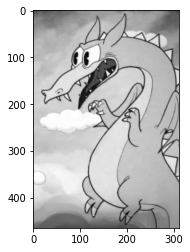

In [192]:
plt.imshow(decoded_img, cmap=plt.cm.gray)